In [1]:
import numpy as np

from scipy.special import j1, struve

from AcousticProperties import *
from GmshBoundaries import *
from RayleighSolver import *
from SamplingPatterns import *
from Plots import *
%matplotlib inline

import gmsh
from joblib import Parallel, delayed


def magnitude(k, boundaryCondition, samples):
    solution = solver.solveBoundary(k, boundaryCondition)
    phi = solver.solveSamples(solution, samples)
    return SoundMagnitude(soundPressure(k, phi))

def theoreticalPressure(R, V, k, r, theta, rho = 1.205, c = 344.0):
    "From Morse & Ingard: Theoretical Acoustics"
    sin_theta = k * R * np.sin(theta)
    f_omega = 2.0 * V * np.pi * R**2 * (2.0 * j1(sin_theta) / sin_theta)
    return -1j * k * rho * c * np.exp(1j * k * r) / (4 * np.pi * r) * f_omega

def theoreticalMagnitude(R, V, k, r, theta, rho = 1.205, c = 344.0):
    return SoundMagnitude(theoreticalPressure(R, V, k, r, theta, rho, c))

def analyticalZm(r, aK, rho, c):
    "From Pierce: Acoustics"
    R1 = 1.0 - 2 * j1(2.0 * aK * r) / (2.0 * aK * r)
    X1 = 2 * struve(1, 2.0 * aK * r) / (2.0 * aK * r)
    Zm = density * c * np.pi * r**2 * (R1 - 1j * X1)
    return Zm

def numericalZm(k, boundaryCondition):
    solution = solver.solveBoundary(k, boundaryCondition)
    return solution.mechanicalImpedance()
 

V = 1.0 # piston velocity
c = 344.0
density = 1.205
nMaxEdge = 0.03

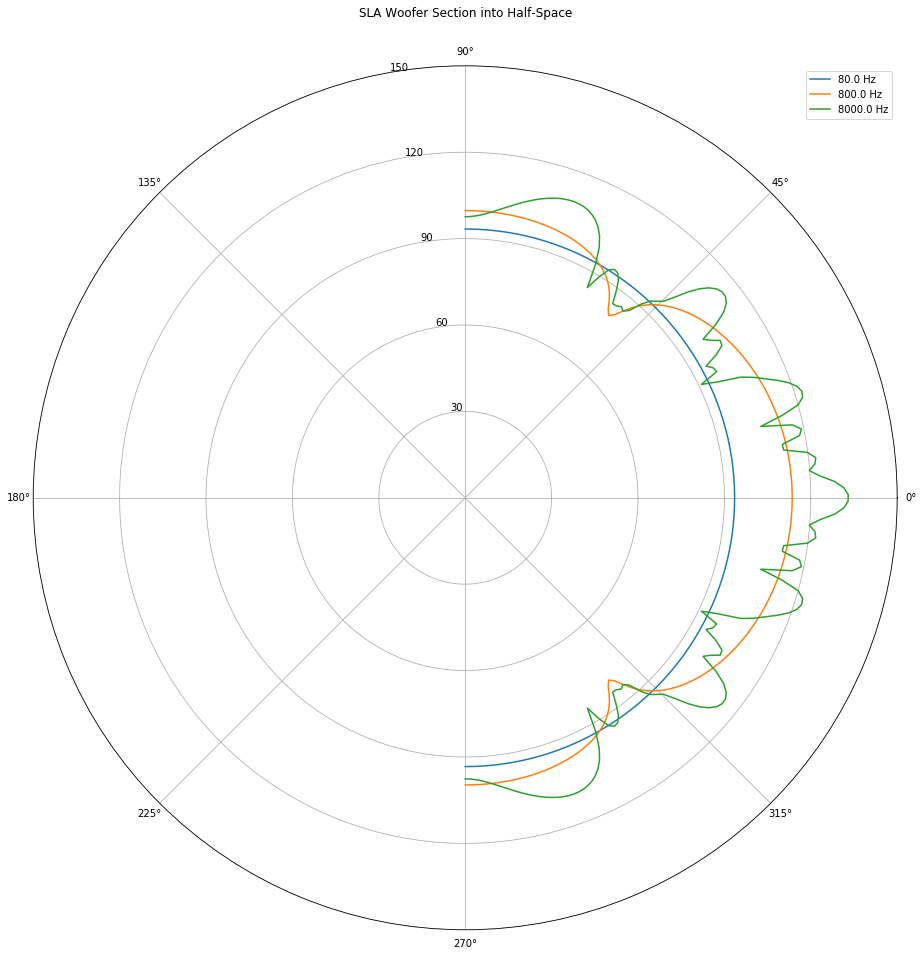

CPU times: user 732 ms, sys: 153 ms, total: 885 ms
Wall time: 7.79 s


In [2]:
%%time

aFrequency = np.array([80, 800, 8000], dtype=np.float32)
aWavenumber = frequencyToWavenumber(aFrequency)

oMesh  = woofersSLA(nMaxEdge) # Fitzmaurice SLA woofer section
solver = RayleighSolver3D(oMesh)
boundaryCondition = solver.neumannBoundaryCondition()
boundaryCondition.f.fill(V)

aSamples, _, aAngle = semiCircle(5, 180, "yz")

aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundaryCondition, aSamples) for k in aWavenumber)

polarPlot("SLA Woofer Section into Half-Space", aFrequency, aAngle, aMagnitudes)

CPU times: user 620 ms, sys: 63.8 ms, total: 684 ms
Wall time: 13min 37s


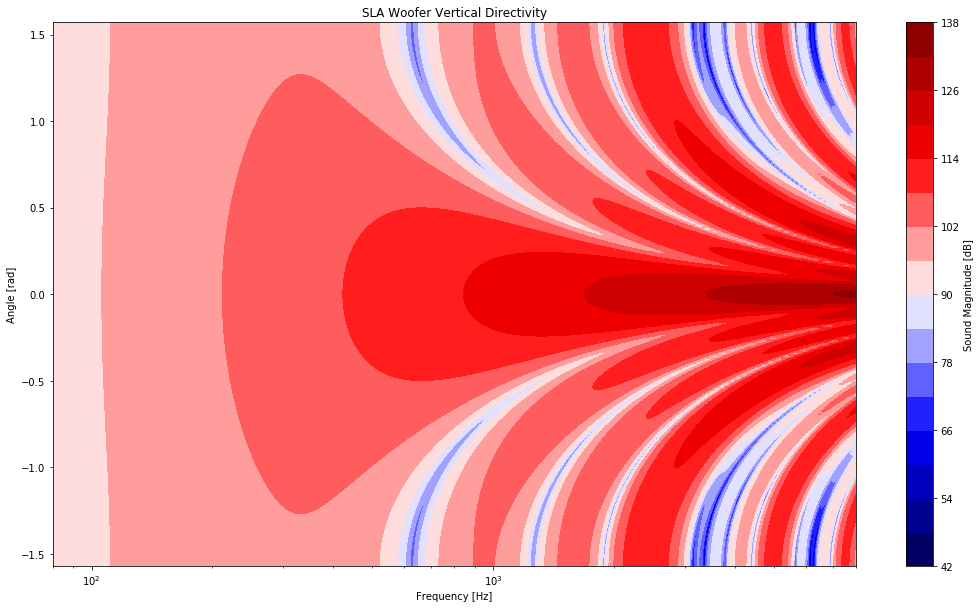

In [3]:
%%time
frequencySamples = 600
aFrequency = np.logspace(np.log10(80), np.log10(8000), frequencySamples)
aWavenumber = frequencyToWavenumber(aFrequency)

angleSamples = 180
aSamples, _, aAngle = semiCircle(5, angleSamples, "yz")

aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundaryCondition, aSamples) for k in aWavenumber)
aMagnitudes = np.asarray(aMagnitudes).transpose()

plotPolarMap('SLA Woofer Vertical Directivity', aFrequency, aAngle, aMagnitudes)


CPU times: user 611 ms, sys: 28.4 ms, total: 639 ms
Wall time: 8min 10s


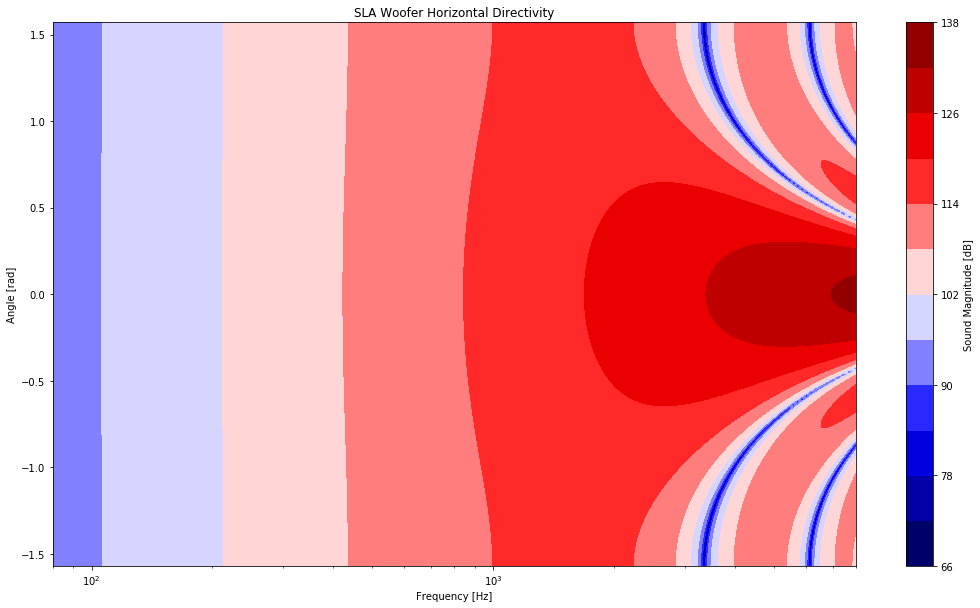

In [4]:
%%time
aSamples, _, aAngle = semiCircle(5, angleSamples, "xz")

aMagnitudes = Parallel(n_jobs=4)(delayed(magnitude)(k, boundaryCondition, aSamples) for k in aWavenumber)
aMagnitudes = np.asarray(aMagnitudes).transpose()

plotPolarMap('SLA Woofer Horizontal Directivity', aFrequency, aAngle, aMagnitudes)


CPU times: user 548 ms, sys: 34.1 ms, total: 582 ms
Wall time: 5min 38s


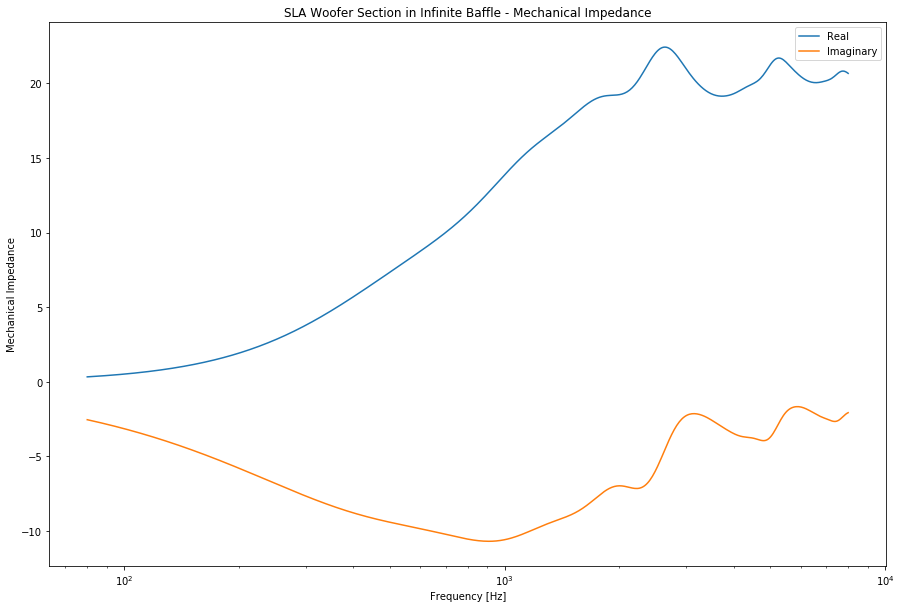

In [5]:
%%time
aNumericalZm = Parallel(n_jobs=4)(delayed(numericalZm)(k, boundaryCondition) for k in aWavenumber)
aNumericalZm = np.asarray(aNumericalZm)

fig, ax = plt.subplots(figsize = (15, 10))
ax.set_title('SLA Woofer Section in Infinite Baffle - Mechanical Impedance')
ax.set_xlabel('Frequency [Hz]')
ax.set_xscale('log') 
ax.set_ylabel('Mechanical Impedance')
ax.plot(aFrequency, np.real(aNumericalZm), label='Real')
ax.plot(aFrequency, np.imag(aNumericalZm), label='Imaginary')
ax.legend()